<a href="https://colab.research.google.com/github/Div12345/SleepStaging-TransferLearning/blob/main/AttentionSleep_Model_Sleep_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Dependencies Install
!pip install wandb
!pip install git+https://github.com/sylvchev/beetl-competition
!pip install moabb
!pip install braindecode
!pip install git+https://github.com/pyRiemann/pyRiemann
!pip install matplotlib
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [ ]:
#@title Imports
from mne import get_config, set_config
import os.path as osp
import os
from beetl.task_datasets import BeetlSleepLeaderboard, BeetlSleepSource
import numpy as np
import pandas as pd
import mne

import braindecode
from braindecode import EEGClassifier
from braindecode.util import np_to_var, set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.datautil.preprocess import preprocess, Preprocessor, zscore
from braindecode.samplers.ssl import RelativePositioningSampler
#from braindecode.datautil import create_from_X_y
from braindecode.datasets import BaseDataset

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import skorch
import skorch.dataset
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring, WandbLogger, TrainEndCheckpoint
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from skorch.classifier import NeuralNetClassifier as NNClassifier

import time
import math
import copy
from copy import deepcopy

import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchsampler import ImbalancedDatasetSampler as IDS

import wandb

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Optional wandb for model logging
!wandb login
# Specific to user - Put it here for convinience

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
mne.set_log_level(False) # Equivalent to WARNING
path = "/content/drive/MyDrive/mne_data"
set_config("MNE_DATA", path)
set_config("MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH",path)
set_config("MNE_DATASETS_BEETLSLEEPSOURCE_PATH",path)
get_config()

<ipython-input-4-d9ce88047e42>:4: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH"
  set_config("MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH",path)
<ipython-input-4-d9ce88047e42>:5: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPSOURCE_PATH"
  set_config("MNE_DATASETS_BEETLSLEEPSOURCE_PATH",path)


{'MNE_DATA': '/content/drive/MyDrive/mne_data',
 'MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH': '/content/drive/MyDrive/mne_data',
 'MNE_DATASETS_BEETLSLEEPSOURCE_PATH': '/content/drive/MyDrive/mne_data'}

In [ ]:
cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if cuda else 'cpu'
print(device)
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=87, cuda=cuda)
random_state = 87

!nvidia-smi -L
# !nvidia-smi -q

# gpu = cuda.get_current_device()
# print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))

cuda
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c3e06580-ab8e-2ffd-1dc1-f3ea7be7b9c2)


In [ ]:
#@title Helper Functions

def label_count(y_train):
  labels= np.unique(y_train)
  labelsize=labels.shape[0]
  #print('labelsize:',labelsize)
  label_count = np.zeros(labelsize).astype(int)
  for i in range(labelsize):
      # tempy = ys1[ys1==labels[i]]
      label_count[i]=y_train[y_train==labels[i]].shape[0]
  maxsize = label_count.max()
  print(label_count)
  return np_to_var(label_count)

def label_viz(y):
  # Another Nice func with viz
  classes_mapping = {0: 'W', 1: 'S1', 2: 'S2', 3: 'S3', 4: 'S4', 5:'REM'}
  # This might be a time consuming method though
  y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
  ax = y_train.value_counts().plot(kind='barh')
  ax.set_xlabel('Number of training examples');
  ax.set_ylabel('Sleep stage');

# For trained Skorch model
def training_viz(clf):
  # For Trained Skorch Classifier
  df = pd.DataFrame(clf.history.to_list())
  df[['train_mis_clf', 'valid_mis_clf']] = 100 - df[
      ['train_bacc', 'valid_bacc']] * 100

  # get percent of misclass for better visual comparison to loss
  plt.style.use('seaborn-talk')
  fig, ax1 = plt.subplots(figsize=(20, 7))
  df.loc[:, ['train_loss', 'valid_loss']].plot(
      ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
      fontsize=14)

  ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
  ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  df.loc[:, ['train_mis_clf', 'valid_mis_clf']].plot(
      ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
  ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
  ax2.set_ylabel('Balanced misclassification rate [%]', color='tab:red',
                fontsize=14)
  ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
  ax1.set_xlabel('Epoch', fontsize=14)

  # where some data has already been plotted to ax
  handles = []
  handles.append(
      Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
  handles.append(
      Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
  plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
  plt.tight_layout()

# Scaling the data
class TrainObject(object):
    # Scaling the data
    def __init__(self, X, y, nps= False):
        assert len(X) == len(y)
        # mean = np.mean(X, axis=2, keepdims=True)
        # # Here normalise across the window, when channel size is not large enough
        # # In motor imagery kit, we put axis = 1, across channel as an example
        # std = np.std(X, axis=2, keepdims=True)
        # X = (X - mean) / std
        X = zscore(X)
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        if (nps == False):
          self.X = np_to_var(X.astype(np.float32)*1e3).to(device)
          self.y = np_to_var(y.astype(np.int8)).to(device)
        else:
          self.X = X.astype(np.float32)*1e3
          self.y = y.astype(np.int8)

def predict_leaderboard_unlabelled(clf, save_fname, x_test_data = None, emb = False,nps=False):
  # Test Data - 6 to 17 - 12 subjects 
  if x_test_data is None:
    _, _, X_test, _ = dsl.get_data(subjects=range(6, 18)) 
    print("Sleep leaderboard - Test Data : There are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

    # print(X_test.shape[0])

    x_test_mean = TrainObject(X_test, y = np.zeros(X_test.shape[0]),nps=nps)
    if (nps==False):
      # means torch must've been the input to the classifier
      x_test_data = Dataset(x_test_mean.X,x_test_mean.y)
      # Maybe put a tqdm bar?
      y_pred = clf.predict(x_test_data)
    else:
      x_test_data = x_test_mean 
      y_pred = clf.predict(x_test_data.X)
  else:
    y_pred = clf.predict(x_test_data)
  print(x_test_data.shape)

  print("Checking if all classes have been predicted")
  print(np.unique(y_pred))
  #@markdown Set the save_path for saving the prediction
  save_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/predict/" #@param
  np.savetxt(save_path+save_fname+".txt",y_pred,delimiter=',',fmt="%d")

In [ ]:
#@title Helper Functions for loading the Data
def get_trainB():
  start = time.time()
  dss = BeetlSleepSource()
  
  start = time.time()
  X_train, y_train, _ = dss.get_data()
  end = time.time()

  print(f"Train data load time {(end-start)/60} min")
  print(X_train.shape,y_train.shape)
  label_count(y_train)

  # z-scoring or normalizing
  
  # start = time.time()
  trainX = TrainObject(X_train, y = y_train, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start}")
  
  start = time.time()
  # trainB = Dataset(trainX)
  trainB = Dataset(trainX.X,trainX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 10 sec + 7 min
  return trainB

def get_valB():
  # valB
  # Labelled Leaderboard Data
  start = time.time()
  dsl = BeetlSleepLeaderboard()
  # dsl.get_data()

  # Validation Data - 5? 6? subjects from the test group - Competition says 5, looks like 6

  X_target, y_target, _, _ = dsl.get_data(subjects=range(0,6))

  end = time.time()
  print(f"leaderboard labelled load time = {(end-start)/60} min")

  print(X_target.shape,y_target.shape)
  label_count(y_target)

  # z-scoring or normalizing
  start = time.time()
  valX = TrainObject(X_target, y = y_target, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")

  
  # for braindecode
  start = time.time()
  valB = Dataset(valX.X,valX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 3 sec + 1.5 min
  return valB

def get_testB():
  dsl = BeetlSleepLeaderboard()
  _, _, X_test, _ = dsl.get_data(subjects=range(6, 18)) 
  print("Sleep leaderboard - Test Data : There are {} trials with {} electrodes and {} time samples".format(*X_test.shape))
  # print(X_test.shape[0])
  # x_test_mean = TrainObject(X_test, y = np.zeros(X_test.shape[0]),nps=nps)

  # z-scoring or normalizing
  start = time.time()
  testX = TrainObject(X_test, y = np.zeros(X_test.shape[0]), nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")
  
  # for braindecode
  start = time.time()
  testB = Dataset(testX.X,testX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  return testB

def get_valC():
  # Phase 2 Target Data
  # Need to download by myself first
  target_savebase = '/content/drive/MyDrive/mne_data/MNE-beetlsleeptest-data/sleep_target/'
  X_sleep_target = []
  y_sleep_target = []
  #from s0-s4 in final set
  start = time.time()
  for subj in range(0, 5):
      for session in range(1, 3):
          # "testing_s{}r{}X.npy", replacing "leaderboard_s{}r{}X.npy" before
          with open(target_savebase + "testing_s{}r{}X.npy".format(subj, session), 'rb') as f:
            X_sleep_target.append(pickle.load(f))
          with open(target_savebase + "testing_s{}r{}y.npy".format(subj, session), 'rb') as g:
            y_sleep_target.append(pickle.load(g))
  X_sleep_target = np.concatenate(X_sleep_target)
  y_sleep_target = np.concatenate(y_sleep_target)


  end = time.time()
  print(f"phase 2 labelled load time = {(end-start)/60} min")

  print("There are {} trials with {} electrodes and {} time samples".format(*X_sleep_target.shape))
  print(X_sleep_target.shape, y_sleep_target.shape)
  label_count(y_sleep_target)

  # package in torch dataset with mean normalizing
  # z-scoring or normalizing
  start = time.time()
  valX = TrainObject(X_sleep_target, y = y_sleep_target, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")

  
  # for braindecode
  start = time.time()
  valC = Dataset(valX.X,valX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 
  return valC

def get_testC():
  # Phase 2 Test Data - Need to download by myself first
  test_savebase = '/content/drive/MyDrive/mne_data/MNE-beetlsleeptest-data/testing/'
  X_sleep_test = []
  start = time.time()

  #starts from s5 in final set
  for subj in range(5, 14):
      for session in range(1, 3):
          # "testing_s{}r{}X.npy", replacing "leaderboard_s{}r{}X.npy" before
          with open(test_savebase + "testing_s{}r{}X.npy".format(subj, session), 'rb') as f:
              X_sleep_test.append(pickle.load(f))
  X_sleep_test = np.concatenate(X_sleep_test)
  end = time.time()
  print(f"phase 2 final test set load time = {(end-start)/60} min")
  print ("There are {} trials with {} electrodes and {} time samples".format(*X_sleep_test.shape))

  # package in torch dataset with mean normalizing
  # z-scoring or normalizing
  start = time.time()
  testX = TrainObject(X_sleep_test, y = np.zeros(X_sleep_test.shape[0]), nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")
  
  # for braindecode
  start = time.time()
  testC = Dataset(testX.X,testX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  return testC

In [ ]:
from time import time as t
def load_obj(path,name):
  target = path + name + '.pkl'
  with open(target, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    a = unpickler.load()
    return a

In [ ]:
# Loading the data as Torch datasets with z-scoring
trainB = get_trainB()
valB = get_valB()
testB = get_testB()

Train data load time 2.091049063205719 min
(90545, 2, 3000) (90545,)
[24043  7941 35983  5247  3057 14274]
Z-scoring time 142.37633633613586
Torch dataset time 0.0035288333892822266 sec = 5.8813889821370444e-05 min
leaderboard labelled load time = 0.3546595533688863 min
(15442, 2, 3000) (15442,)
[6010 1672 5035  704  414 1607]
Z-scoring time 1.0841395854949951 sec
Torch dataset time 9.655952453613281e-05 sec = 1.6093254089355469e-06 min
Sleep leaderboard - Test Data : There are 25748 trials with 2 electrodes and 3000 time samples
Z-scoring time 1.6269407272338867 sec
Torch dataset time 7.843971252441406e-05 sec = 1.3073285420735677e-06 min


In [ ]:
print(trainB)
print(valB)
print(testB)

# AttnSleep

In [ ]:
#@title Utilities Functions
# calc_class_weight
def calc_class_weight(labels_count):
    total = np.sum(labels_count)
    class_weight = dict()
    num_classes = len(labels_count)

    factor = 1 / num_classes
    # adding a factor for S4 as 1.5
    # original work was AASM only till N3 = S3+S4
    mu = [factor * 1.5, factor * 2, factor * 1.5, factor,factor*1.5, factor * 1.5]

    for key in range(num_classes):
        score = math.log(mu[key] * total / float(labels_count[key]))
        class_weight[key] = score if score > 1.0 else 1.0
        class_weight[key] = round(class_weight[key] * factor, 2)

    class_weight = [class_weight[i] for i in range(num_classes)]

    return class_weight

In [ ]:
#@title AttnSleep helper modules

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, 1)
        self.bn2 = nn.BatchNorm1d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class GELU(nn.Module):
    # for older versions of PyTorch.  For new versions you can use nn.GELU() instead.
    def __init__(self):
        super(GELU, self).__init__()
        
    def forward(self, x):
        x = torch.nn.functional.gelu(x)
        return x
        
        
class MRCNN(nn.Module):
    def __init__(self, afr_reduced_cnn_size):
        super(MRCNN, self).__init__()
        drate = 0.5
        self.GELU = GELU()  # for older versions of PyTorch.  For new versions use nn.GELU() instead.
        self.features1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, bias=False, padding=24),
            nn.BatchNorm1d(64),
            self.GELU,
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(drate),

            nn.Conv1d(64, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.Conv1d(128, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        self.features2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=400, stride=50, bias=False, padding=200),
            nn.BatchNorm1d(64),
            self.GELU,
            nn.MaxPool1d(kernel_size=4, stride=2, padding=2),
            nn.Dropout(drate),

            nn.Conv1d(64, 128, kernel_size=7, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.Conv1d(128, 128, kernel_size=7, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            self.GELU,

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )
        self.dropout = nn.Dropout(drate)
        self.inplanes = 128
        self.AFR = self._make_layer(SEBasicBlock, afr_reduced_cnn_size, 1)

    def _make_layer(self, block, planes, blocks, stride=1):  # makes residual SE block
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.features1(x)
        x2 = self.features2(x)
        x_concat = torch.cat((x1, x2), dim=2)
        x_concat = self.dropout(x_concat)
        x_concat = self.AFR(x_concat)
        return x_concat

##########################################################################################


def attention(query, key, value, dropout=None):
    "Implementation of Scaled dot product attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, afr_reduced_cnn_size, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h

        self.convs = clones(CausalConv1d(afr_reduced_cnn_size, afr_reduced_cnn_size, kernel_size=7, stride=1), 3)
        self.linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        "Implements Multi-head attention"
        nbatches = query.size(0)

        query = query.view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        key   = self.convs[1](key).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        value = self.convs[2](value).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)

        x, self.attn = attention(query, key, value, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_k)

        return self.linear(x)


class LayerNorm(nn.Module):
    "Construct a layer normalization module."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    '''
    A residual connection followed by a layer norm.
    '''

    def __init__(self, size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCE(nn.Module):
    '''
    Transformer Encoder
    It is a stack of N layers.
    '''

    def __init__(self, layer, N):
        super(TCE, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)


class EncoderLayer(nn.Module):
    '''
    An encoder layer
    Made up of self-attention and a feed forward layer.
    Each of these sublayers have residual and layer norm, implemented by SublayerOutput.
    '''
    def __init__(self, size, self_attn, feed_forward, afr_reduced_cnn_size, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(size, dropout), 2)
        self.size = size
        self.conv = CausalConv1d(afr_reduced_cnn_size, afr_reduced_cnn_size, kernel_size=7, stride=1, dilation=1)


    def forward(self, x_in):
        "Transformer Encoder"
        query = self.conv(x_in)
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))  # Encoder self-attention
        return self.sublayer_output[1](x, self.feed_forward)


class PositionwiseFeedForward(nn.Module):
    "Positionwise feed-forward network."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        "Implements FFN equation."
        return self.w_2(self.dropout(F.relu(self.w_1(x))))



In [ ]:
#@title AttnSleep Model for Physionet

class AttnSleep(nn.Module):
    def __init__(self):
        super(AttnSleep, self).__init__()

        N = 2  # number of TCE clones
        d_model = 80  # set to be 100 for SHHS dataset
        d_ff = 120   # dimension of feed forward
        h = 5  # number of attention heads
        dropout = 0.1 #@param
        num_classes = 6 #@param
        afr_reduced_cnn_size = 30

        self.mrcnn = MRCNN(afr_reduced_cnn_size) # use MRCNN_SHHS for SHHS dataset

        attn = MultiHeadedAttention(h, d_model, afr_reduced_cnn_size)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.tce = TCE(EncoderLayer(d_model, deepcopy(attn), deepcopy(ff), afr_reduced_cnn_size, dropout), N)

        self.fc = nn.Linear(d_model * afr_reduced_cnn_size, num_classes)

    def forward(self, x):
        x_feat = self.mrcnn(x)
        encoded_features = self.tce(x_feat)
        encoded_features = encoded_features.contiguous().view(encoded_features.shape[0], -1)
        final_output = self.fc(encoded_features)
        return final_output
    
    # def train(self, mode=True):
    #     """
    #     Override the default train() to freeze the BN parameters
    #     """
        
    #     super(AttnSleep, self).train(mode)
    #     if self.freeze_bn:
    #         print("Freezing Mean/Var of BatchNorm2D.")
    #         if self.freeze_bn_affine:
    #             print("Freezing Weight/Bias of BatchNorm2D.")
    #     if self.freeze_bn:
    #         for m in self.backbone.modules():
    #             if isinstance(m, nn.BatchNorm2d):
    #                 m.eval()
    #                 if self.freeze_bn_affine:
    #                     m.weight.requires_grad = False
    #                     m.bias.requires_grad = False

######################################################################


In [ ]:
# Write the Skorch wrapper classifier
# Or maybe use braindecode directly over this? But I don't see a benefit to be honest
# Go for skorch

model = AttnSleep()
if cuda:
    model.cuda()
print(model)

AttnSleep(
  (mrcnn): MRCNN(
    (GELU): GELU()
    (features1): Sequential(
      (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,), padding=(24,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
      (3): MaxPool1d(kernel_size=8, stride=2, padding=4, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU()
      (8): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): GELU()
      (11): MaxPool1d(kernel_size=4, stride=4, padding=2, dilation=1, ceil_mode=False)
    )
    (features2): Sequential(
      (0): Conv1d(1, 64, kernel_size=(400,), stride=(50,), padding=(200,), bias=False)
    

In [ ]:
# This model takes in data of single channel - Paper took Pz-Oz
# Need to create new Pytorch Dataset with single channel

# Channel 0
trainA0 = Dataset(trainB.X[:,0,:].unsqueeze(1),trainB.y.long())
valA0 = Dataset(valB.X[:,0,:].unsqueeze(1),valB.y.long())

# Channel 1
# trainA1 = Dataset(trainB.X[:,1,:].unsqueeze(1),trainB.y.long())
# valA1 = Dataset(valB.X[:,1,:].unsqueeze(1),valB.y.long())

In [ ]:
#@title Weighted Cross Entropy Loss (with hard coded weights - change for continued training)
import torch
import torch.nn as nn

class weighted_CrossEntropyLoss():
  def __call__(self,output, target):
    # hard-coded because not sure of how to pass weights when giving loss function to skorch
    classes_weights = [0.17, 0.22, 0.17, 0.18, 0.33, 0.17]
    # print(output, target)
    # print(type(output), type(target))
    # print(type(output.long()),type(target.long()))
    cr = nn.CrossEntropyLoss(weight=torch.tensor(classes_weights).to(device))
    return cr(output, target)

# Training of the model on Group 1 data using Channel 0

In [ ]:
# Retrain and save other things in checkpointing like params, etc. other than pickle.. Looks like pickle won't work for this model

# starting wandb init
# comment out for non-wandb run
wandb_run = wandb.init(name = "AttnSleep", project='cnn-fulltrain', entity='sleep_hacking')

# batch_size
lr = 1e-3 #change
batch_size = 1024
n_epochs = 100

channel = 0
save_path = "/content/drive/MyDrive/mne_data/AttnSleep2r_checkpoints"
wandb_run.config.update({"lr":lr,"batch_size":batch_size,"channel":channel,"save_path":save_path})

train_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bacc',
    lower_is_better=False)
valid_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bacc',
    lower_is_better=False)

cp = Checkpoint(monitor = 'valid_bacc_best',
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname = save_path)
train_end_cp = TrainEndCheckpoint(
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname=save_path)

# f1, accuracy
callbacks = [('train_bal_acc', train_bacc),
             ('valid_bal_acc', valid_bacc),
             ("checkpoint",cp),
             ("train_end_cp",train_end_cp),
             ("wandb",WandbLogger(wandb_run)) # comment out for non-wandb run
            ]


# loss = getattr(weighted_CrossEntropyLoss, 'forward')

clf2 = NNClassifier(
  module = AttnSleep,
  criterion = weighted_CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  train_split=predefined_split(valA0),
  iterator_train = DataLoader,
  optimizer__lr=lr,
  batch_size=batch_size,
  callbacks=callbacks,
  device=device
)
# callback metric f1, accuracy
# 
print(clf)

wandb: Currently logged in as: div12345 (use `wandb login --relogin` to force relogin)


<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.AttnSleep'>,
)


In [ ]:
start = time.time()
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
# clf.fit(dl.dataset.X.cpu(), y=dl.dataset.y.cpu(), epochs=n_epochs)
clf.fit(trainA0, y=None, epochs=n_epochs)
end = time.time()
print(f'time taken : {end-start}')
# saving
# with open('/content/drive/MyDrive/mne_data/AttnSleep2_100.pkl', 'wb') as f:
#     pickle.dump(model, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss    cp      dur
-------  ------------  ------------  -----------  ------------  ------------  ----  -------
      1        0.3699        1.3060       0.6611        0.4981        0.9942     +  20.8272
      2        0.4655        0.9941       0.6396        0.5161        1.0272     +  17.1405
      3        0.4993        0.9176       0.6316        0.5330        1.0662     +  17.3853
      4        0.5298        0.8638       0.6094        0.5319        1.0911        17.4876
      5        0.5399        0.8224       0.6024        0.5282        1.1955        17.3755
      6        0.5625        0.7857       0.6151        0.5462        1.1233     +  17.2831
      7        0.5748        0.7595       0.6398        0.5621        1.0181     +  17.2074
      8        0.5817        0.7489       0.6684        0.5535        0.9651        17.3004
      9        0.5827        0.7438       0.6620        0.5441        0.9597    

In [ ]:
# Load from checkpoint

# clf.load_params(checkpoint=cp) # soesn't seem to have loaded it

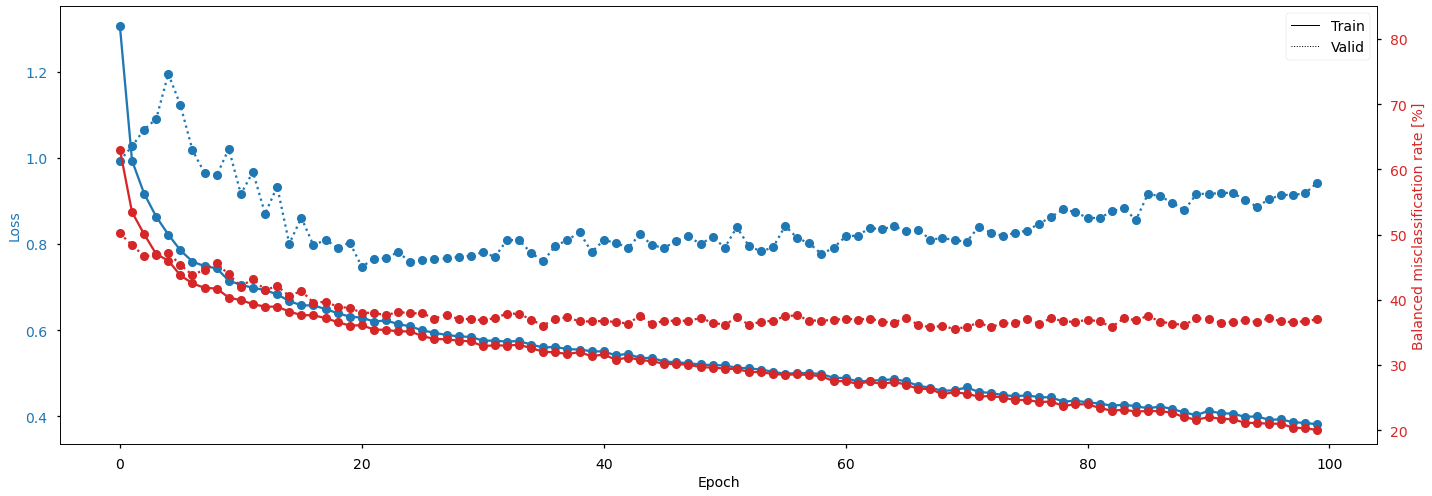

In [ ]:
training_viz(clf)

In [ ]:
y_true = valA0.y
y_pred = clf.predict(valA0.X)

print("From Last Checkpointed model")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model
[[4963  475   94    7    3  468]
 [ 174  450  604   13   11  420]
 [  67  271 3617  428  237  415]
 [   0    4  131  231  310   28]
 [   0    0   10   38  364    2]
 [  46  169  173    1    0 1218]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      6010
           1       0.33      0.27      0.30      1672
           2       0.78      0.72      0.75      5035
           3       0.32      0.33      0.32       704
           4       0.39      0.88      0.54       414
           5       0.48      0.76      0.59      1607

    accuracy                           0.70     15442
   macro avg       0.54      0.63      0.56     15442
weighted avg       0.73      0.70      0.71     15442

0.5972200545917337


In [ ]:
# Try loading the checkpointed model


# Using first group trained model and prediction on the final test set (Submitted model predictions)

In [ ]:
# Load the Channel 0, batch_size 1024 model
# starting wandb init
wandb_run = wandb.init(name = "AttnSleep_TL_new1", project='cnn-fulltrain', entity='sleep_hacking')

# batch_size
lr = 1e-3 #change
batch_size = 1024
n_epochs = 100

channel = 0
save_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleepTLnew1_checkpoints"
wandb_run.config.update({"lr":lr,"batch_size":batch_size,"channel":channel,"save_path":save_path})

train_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bacc',
    lower_is_better=False)
cp = Checkpoint(monitor = 'train_bacc_best',
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname = save_path)
train_end_cp = TrainEndCheckpoint(
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname=save_path)
# f1, accuracy
callbacks = [('train_bal_acc', train_bacc),
             ("checkpoint",cp),
             ("train_end_cp",train_end_cp),
             ("wandb",WandbLogger(wandb_run,save_model=False))
            ]

clf5 = NNClassifier(
  module = AttnSleep,
  criterion = weighted_CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  train_split=None,
  iterator_train = DataLoader,
  optimizer__lr=lr,
  batch_size=batch_size,
  callbacks=callbacks,
  warm_start = True,
  device=device
)
print(clf5)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.AttnSleep'>,
)


In [ ]:
clf5.initialize() # This is important!

# Loading from the group 1 trained model
load_path ="/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleep2r_checkpoints"
clf5.load_params(
    f_params=load_path+'/params_70.pt', f_optimizer=load_path+'/optimizer_70.pt')

In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


From Last Checkpointed model - Prediction on Leaderboard Validation data
[[5132  468   54    4    1  351]
 [ 199  543  509    9    9  403]
 [  85  335 3544  335  238  498]
 [   3    6  113  213  313   56]
 [   0    0   10   37  365    2]
 [  43  147  125    1    0 1291]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6010
           1       0.36      0.32      0.34      1672
           2       0.81      0.70      0.75      5035
           3       0.36      0.30      0.33       704
           4       0.39      0.88      0.54       414
           5       0.50      0.80      0.61      1607

    accuracy                           0.72     15442
   macro avg       0.56      0.65      0.58     15442
weighted avg       0.75      0.72      0.72     15442

0.6184415147452027


In [ ]:
#checking if loaded properly
# Untrained
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Untrained - Prediction on Phase 2 Validation Data before TL training")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Untrained - Prediction on Phase 2 Validation Data before TL training
[[7090  469   48    5    5  192]
 [ 296  614  216   52   18  443]
 [ 185  642 1271  607  442 1557]
 [  18    2   18  147  471   33]
 [   3    0    0    7  134    1]
 [ 121  295  170   36   14  946]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      7809
           1       0.30      0.37      0.34      1639
           2       0.74      0.27      0.40      4704
           3       0.17      0.21      0.19       689
           4       0.12      0.92      0.22       145
           5       0.30      0.60      0.40      1582

    accuracy                           0.62     16568
   macro avg       0.43      0.55      0.41     16568
weighted avg       0.71      0.62      0.62     16568

0.4648407938486785


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training
[[7620  113   48    4    0   24]
 [ 413  510  559    9    1  147]
 [  75  248 4011  120   19  231]
 [   1    1  258  329  100    0]
 [   0    0    7   44   94    0]
 [ 140  207  336   10    0  889]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7809
           1       0.47      0.31      0.38      1639
           2       0.77      0.85      0.81      4704
           3       0.64      0.48      0.55       689
           4       0.44      0.65      0.52       145
           5       0.69      0.56      0.62      1582

    accuracy                           0.81     16568
   macro avg       0.66      0.64      0.64     16568
weighted avg       0.80      0.81      0.80     16568

0.7153917831791735


In [ ]:
start = time.time()
clf5.fit(valC0, y=None, epochs=n_epochs)
end = time.time()
print(f'time taken : {end-start}')

  epoch    train_bacc    train_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5604        0.7493     +  3.5063
      2        0.5598        0.6494        1.8288
      3        0.5960        0.6319     +  1.8325
      4        0.6185        0.5626     +  1.8338
      5        0.6557        0.5239     +  1.9436
      6        0.6666        0.5075     +  1.9028
      7        0.6869        0.5017     +  1.8480
      8        0.6829        0.4941        1.8449
      9        0.6921        0.4771     +  1.9497
     10        0.7001        0.4696     +  1.8465
     11        0.7022        0.4595     +  1.8442
     12        0.7240        0.4471     +  1.8710
     13        0.7259        0.4401     +  1.9547
     14        0.7354        0.4373     +  1.8433
     15        0.7399        0.4290     +  1.8422
     16        0.7334        0.4226        1.8441
     17        0.7572        0.4084     +  1.9409
     18        0.7418        0.4086        1.8627


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val
[[7773   19    6    0    0   11]
 [  26 1517   76    6    0   14]
 [   6   16 4635    7    0   40]
 [   0    0   67  622    0    0]
 [   0    0    1    1  143    0]
 [   7    4   38    1    0 1532]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7809
           1       0.97      0.93      0.95      1639
           2       0.96      0.99      0.97      4704
           3       0.98      0.90      0.94       689
           4       1.00      0.99      0.99       145
           5       0.96      0.97      0.96      1582

    accuracy                           0.98     16568
   macro avg       0.98      0.96      0.97     16568
weighted avg       0.98      0.98      0.98     16568

0.9690586799902011


In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val
[[5286  325  153    6    4  236]
 [ 297  473  603    0    0  299]
 [ 159  413 4216   13    1  233]
 [   0    5  639   53    5    2]
 [   0    0  264  105   45    0]
 [ 181  267  231    0    0  928]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      6010
           1       0.32      0.28      0.30      1672
           2       0.69      0.84      0.76      5035
           3       0.30      0.08      0.12       704
           4       0.82      0.11      0.19       414
           5       0.55      0.58      0.56      1607

    accuracy                           0.71     15442
   macro avg       0.59      0.46      0.47     15442
weighted avg       0.70      0.71      0.69     15442

0.5887597621244347


In [ ]:
#checking if loaded properly
y_true = trainA0.y
y_pred = clf5.predict(trainA0.X)

print("From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data
[[21398  1036   544    30     5  1030]
 [ 1252  1726  2869     3     1  2090]
 [  432  1516 32128   215     7  1685]
 [   16    11  4239   855   103    23]
 [    2     0  1598   904   552     1]
 [  817  1067  3330    21     2  9037]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     24043
           1       0.32      0.22      0.26      7941
           2       0.72      0.89      0.80     35983
           3       0.42      0.16      0.24      5247
           4       0.82      0.18      0.30      3057
           5       0.65      0.63      0.64     14274

    accuracy                           0.73     90545
   macro avg       0.64      0.50      0.52     90545
weighted avg       0.71      0.73      0.70     90545

0.6094841107515762


In [ ]:
predict_leaderboard_unlabelled(clf=clf5,save_fname="AttnSleep_TL_slightTL", x_test_data = testC.X[:,channel,:].unsqueeze(1))

torch.Size([25756, 1, 3000])
Checking if all classes have been predicted
[0 1 2 3 4 5]


This model got 63.8% on the Sleep Leaderboard. Without the TL it was at 60%.. Not such a great improvement.. Seems like Overfitting on the 5 subject data wasn't enough to generalize to all the leaderboard data..

In [ ]:
wandb.finish()

dur,1.87056
train_bacc,0.96911
train_loss,0.05969


dur,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_bacc,▁▂▃▃▃▄▄▄▄▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇█▇██████
train_loss,█▇▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


# Other Tries

The following code are not necessary for replicating the model and performance submitted to the Hackathon but show the other techniques tried

# 2nd Level TL using model on which leaderboard TL has been done and prediction on final test set - *Not* the model whose predictions was submitted

The leaderboard data can be used in testing phase

I'm not sure if the target data provided for the test is the same as the labelled target in the leaderboard

In [ ]:
valC = get_valC()
testC = get_testC()

phase 2 labelled load time = 0.3309566259384155 min
There are 16568 trials with 2 electrodes and 3000 time samples
(16568, 2, 3000) (16568,)
[7809 1639 4704  689  145 1582]
Z-scoring time 7.114246129989624 sec
Torch dataset time 0.0020368099212646484 sec = 3.394683202107747e-05 min
phase 2 final test set load time = 0.3870764295260111 min
There are 25756 trials with 2 electrodes and 3000 time samples
Z-scoring time 1.73142409324646 sec
Torch dataset time 6.651878356933594e-05 sec = 1.1086463928222657e-06 min


In [ ]:
valC0 = Dataset(valC.X[:,0,:].unsqueeze(1),valC.y.long())
testC0 = Dataset(testC.X[:,0,:].unsqueeze(1),testC.y.long())

In [ ]:
# Load the leaderboard overfitted model that gave maximum performance till now

In [ ]:
# Load the Channel 0, batch_size 1024 model
# starting wandb init
wandb_run = wandb.init(name = "AttnSleep_TL_new", project='cnn-fulltrain', entity='sleep_hacking')

# model = clf.module

# batch_size
lr = 1e-3 #change
batch_size = 1024
n_epochs = 100

channel = 0
save_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleepTLnew0_checkpoints"
wandb_run.config.update({"lr":lr,"batch_size":batch_size,"channel":channel,"save_path":save_path})

train_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bacc',
    lower_is_better=False)
cp = Checkpoint(monitor = 'train_bacc_best',
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname = save_path)
train_end_cp = TrainEndCheckpoint(
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname=save_path)

callbacks = [('train_bal_acc', train_bacc),
             ("checkpoint",cp),
             ("train_end_cp",train_end_cp),
             ("wandb",WandbLogger(wandb_run,save_model=False))
            ]

clf5 = NNClassifier(
  module = AttnSleep,
  criterion = weighted_CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  train_split=None,
  iterator_train = DataLoader,
  optimizer__lr=lr,
  batch_size=batch_size,
  callbacks=callbacks,
  warm_start = True,
  device=device
)
print(clf5)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.AttnSleep'>,
)


In [ ]:
clf5.initialize() # This is important!
load_path ="/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleepTL0_checkpoints"

clf5.load_params(
    f_params=load_path+'/params_100.pt', f_optimizer=load_path+'/optimizer_100.pt')

In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Leaderboard Validation data
[[5848   55   23    1    2   81]
 [  25 1474  119    6    6   42]
 [  23   43 4657  197   72   43]
 [   0    0   15  638   50    1]
 [   0    0    1    1  412    0]
 [  10   15   27    0    0 1555]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6010
           1       0.93      0.88      0.90      1672
           2       0.96      0.92      0.94      5035
           3       0.76      0.91      0.82       704
           4       0.76      1.00      0.86       414
           5       0.90      0.97      0.93      1607

    accuracy                           0.94     15442
   macro avg       0.88      0.94      0.91     15442
weighted avg       0.95      0.94      0.95     15442

0.923122533570641


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training
[[7235  341   56    9    3  165]
 [ 319  412  501   67   12  328]
 [ 117  323 2715  915  353  281]
 [   5    3   31  198  450    2]
 [   2    0    0    6  137    0]
 [ 107  234  400   57   13  771]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7809
           1       0.31      0.25      0.28      1639
           2       0.73      0.58      0.65      4704
           3       0.16      0.29      0.20       689
           4       0.14      0.94      0.25       145
           5       0.50      0.49      0.49      1582

    accuracy                           0.69     16568
   macro avg       0.46      0.58      0.47     16568
weighted avg       0.73      0.69      0.71     16568

0.5568759416152871


In [ ]:
start = time.time()
clf5.fit(valC0, y=None, epochs=n_epochs)
end = time.time()
print(f'time taken : {end-start}')

  epoch    train_bacc    train_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5004        1.2982     +  2.3097
      2        0.5097        0.8621     +  1.8406
      3        0.5890        0.6924     +  1.9452
      4        0.5725        0.6719        1.8371
      5        0.6155        0.6118     +  1.8451
      6        0.6579        0.5650     +  1.8641
      7        0.6687        0.5269     +  1.9545
      8        0.6736        0.5111     +  1.8410
      9        0.6981        0.4863     +  1.8510
     10        0.7148        0.4744     +  1.8334
     11        0.7032        0.4693        1.8448
     12        0.7222        0.4613     +  1.9981
     13        0.7257        0.4486     +  1.8425
     14        0.7500        0.4334     +  1.8387
     15        0.7425        0.4306        1.8436
     16        0.7503        0.4230     +  1.9559
     17        0.7484        0.4131        1.8315
     18        0.7663        0.4023     +  1.8753


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val
[[7790    7    3    1    1    7]
 [  39 1476   42    0    0   82]
 [   9   20 4415   21    1  238]
 [   0    0   42  647    0    0]
 [   0    0    0    1  144    0]
 [   9    0    5    0    0 1568]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7809
           1       0.98      0.90      0.94      1639
           2       0.98      0.94      0.96      4704
           3       0.97      0.94      0.95       689
           4       0.99      0.99      0.99       145
           5       0.83      0.99      0.90      1582

    accuracy                           0.97     16568
   macro avg       0.96      0.96      0.96     16568
weighted avg       0.97      0.97      0.97     16568

0.9529875599569695


In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val
[[5451  201   97   10    2  249]
 [ 249  469  453    0    2  499]
 [ 103  253 4124   20    2  533]
 [   1    2  612   83    2    4]
 [   0    0  236  140   38    0]
 [ 140   65  113    0    2 1287]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6010
           1       0.47      0.28      0.35      1672
           2       0.73      0.82      0.77      5035
           3       0.33      0.12      0.17       704
           4       0.79      0.09      0.16       414
           5       0.50      0.80      0.62      1607

    accuracy                           0.74     15442
   macro avg       0.62      0.50      0.50     15442
weighted avg       0.74      0.74      0.72     15442

0.6340654649550557


In [ ]:
#checking if loaded properly
y_true = trainA0.y
y_pred = clf5.predict(trainA0.X)

print("From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data
[[21626   662   436    26    12  1281]
 [ 1440   991  2215     7     0  3288]
 [  850  1001 30391   255     7  3479]
 [   26    16  4133   974    81    17]
 [    0     1  1372  1318   365     1]
 [ 1244   440  1988    30     2 10570]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     24043
           1       0.32      0.12      0.18      7941
           2       0.75      0.84      0.79     35983
           3       0.37      0.19      0.25      5247
           4       0.78      0.12      0.21      3057
           5       0.57      0.74      0.64     14274

    accuracy                           0.72     90545
   macro avg       0.61      0.49      0.49     90545
weighted avg       0.69      0.72      0.69     90545

0.6018683529800133


Good Example of Catastrophic Forgetting, but group staying at around 60% is interesting

In [ ]:
predict_leaderboard_unlabelled(clf=clf5,save_fname="AttnSleep_TL_final0", x_test_data = testC.X[:,channel,:].unsqueeze(1))

torch.Size([25756, 1, 3000])
Checking if all classes have been predicted
[0 1 2 3 4 5]


This model got 63.8% on the Sleep Leaderboard. Without the TL it was at 60%.. Not such a great improvement.. Seems like Overfitting on the 5 subject data wasn't enough to generalize to all the leaderboard data..

In [ ]:
wandb.finish()

dur,1.86337
train_bacc,0.96495
train_loss,0.07148


dur,█▃▂▁▁▁▃▂▃▁▃▁▁▃▂▃▁▁▁▁▁▁▃▂▁▁▁▃▁▁▁▁▃▁▁▂▁▁▁▁
train_bacc,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇███████████████
train_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# TL using first group trained model and target data of the final set (Primarily led to overfitting and performance lower than non-TL direct model)

In [ ]:
valC = get_valC()
testC = get_testC()

phase 2 labelled load time = 0.3309566259384155 min
There are 16568 trials with 2 electrodes and 3000 time samples
(16568, 2, 3000) (16568,)
[7809 1639 4704  689  145 1582]
Z-scoring time 7.114246129989624 sec
Torch dataset time 0.0020368099212646484 sec = 3.394683202107747e-05 min
phase 2 final test set load time = 0.3870764295260111 min
There are 25756 trials with 2 electrodes and 3000 time samples
Z-scoring time 1.73142409324646 sec
Torch dataset time 6.651878356933594e-05 sec = 1.1086463928222657e-06 min


In [ ]:
# Channel 0
valC0 = Dataset(valC.X[:,0,:].unsqueeze(1),valC.y.long())
testC0 = Dataset(testC.X[:,0,:].unsqueeze(1),testC.y.long())

In [ ]:
# Load the Channel 0, batch_size 1024 model
# starting wandb init
wandb_run = wandb.init(name = "AttnSleep_TL_new", project='cnn-fulltrain', entity='sleep_hacking')

# model = clf.module

# batch_size
lr = 1e-3 #change
batch_size = 1024
n_epochs = 100

channel = 0
save_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleepTLnew0_checkpoints"
wandb_run.config.update({"lr":lr,"batch_size":batch_size,"channel":channel,"save_path":save_path})

train_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bacc',
    lower_is_better=False)
cp = Checkpoint(monitor = 'train_bacc_best',
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname = save_path)
train_end_cp = TrainEndCheckpoint(
                f_params = "params_{last_epoch[epoch]}.pt", 
                f_optimizer = "optimizer_{last_epoch[epoch]}.pt", 
                f_criterion = "criterion_{last_epoch[epoch]}.pt",
                dirname=save_path)

callbacks = [('train_bal_acc', train_bacc),
             ("checkpoint",cp),
             ("train_end_cp",train_end_cp),
             ("wandb",WandbLogger(wandb_run,save_model=False))
            ]

clf5 = NNClassifier(
  module = AttnSleep,
  criterion = weighted_CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  train_split=None,
  iterator_train = DataLoader,
  optimizer__lr=lr,
  batch_size=batch_size,
  callbacks=callbacks,
  warm_start = True,
  device=device
)
print(clf5)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.AttnSleep'>,
)


In [ ]:
clf5.initialize() # This is important!
load_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/AttnSleepTLnew1_checkpoints"
clf5.load_params(
    f_params=load_path+'/params_3.pt', f_optimizer=load_path+'/optimizer_3.pt')

In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Leaderboard Validation data
[[5848   55   23    1    2   81]
 [  25 1474  119    6    6   42]
 [  23   43 4657  197   72   43]
 [   0    0   15  638   50    1]
 [   0    0    1    1  412    0]
 [  10   15   27    0    0 1555]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6010
           1       0.93      0.88      0.90      1672
           2       0.96      0.92      0.94      5035
           3       0.76      0.91      0.82       704
           4       0.76      1.00      0.86       414
           5       0.90      0.97      0.93      1607

    accuracy                           0.94     15442
   macro avg       0.88      0.94      0.91     15442
weighted avg       0.95      0.94      0.95     15442

0.923122533570641


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation Data before TL training
[[7235  341   56    9    3  165]
 [ 319  412  501   67   12  328]
 [ 117  323 2715  915  353  281]
 [   5    3   31  198  450    2]
 [   2    0    0    6  137    0]
 [ 107  234  400   57   13  771]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7809
           1       0.31      0.25      0.28      1639
           2       0.73      0.58      0.65      4704
           3       0.16      0.29      0.20       689
           4       0.14      0.94      0.25       145
           5       0.50      0.49      0.49      1582

    accuracy                           0.69     16568
   macro avg       0.46      0.58      0.47     16568
weighted avg       0.73      0.69      0.71     16568

0.5568759416152871


In [ ]:
start = time.time()
clf5.fit(valC0, y=None, epochs=n_epochs)
end = time.time()
print(f'time taken : {end-start}')

  epoch    train_bacc    train_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5004        1.2982     +  2.3097
      2        0.5097        0.8621     +  1.8406
      3        0.5890        0.6924     +  1.9452
      4        0.5725        0.6719        1.8371
      5        0.6155        0.6118     +  1.8451
      6        0.6579        0.5650     +  1.8641
      7        0.6687        0.5269     +  1.9545
      8        0.6736        0.5111     +  1.8410
      9        0.6981        0.4863     +  1.8510
     10        0.7148        0.4744     +  1.8334
     11        0.7032        0.4693        1.8448
     12        0.7222        0.4613     +  1.9981
     13        0.7257        0.4486     +  1.8425
     14        0.7500        0.4334     +  1.8387
     15        0.7425        0.4306        1.8436
     16        0.7503        0.4230     +  1.9559
     17        0.7484        0.4131        1.8315
     18        0.7663        0.4023     +  1.8753


In [ ]:
#checking if loaded properly
y_true = valC0.y
y_pred = clf5.predict(valC0.X)

print("From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Phase 2 Validation data after TL training on Phase 2 val
[[7790    7    3    1    1    7]
 [  39 1476   42    0    0   82]
 [   9   20 4415   21    1  238]
 [   0    0   42  647    0    0]
 [   0    0    0    1  144    0]
 [   9    0    5    0    0 1568]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7809
           1       0.98      0.90      0.94      1639
           2       0.98      0.94      0.96      4704
           3       0.97      0.94      0.95       689
           4       0.99      0.99      0.99       145
           5       0.83      0.99      0.90      1582

    accuracy                           0.97     16568
   macro avg       0.96      0.96      0.96     16568
weighted avg       0.97      0.97      0.97     16568

0.9529875599569695


In [ ]:
#checking if loaded properly
y_true = valA0.y
y_pred = clf5.predict(valA0.X)

print("From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on Leaderboard Validation data after TL training on Phase 2 val
[[5451  201   97   10    2  249]
 [ 249  469  453    0    2  499]
 [ 103  253 4124   20    2  533]
 [   1    2  612   83    2    4]
 [   0    0  236  140   38    0]
 [ 140   65  113    0    2 1287]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6010
           1       0.47      0.28      0.35      1672
           2       0.73      0.82      0.77      5035
           3       0.33      0.12      0.17       704
           4       0.79      0.09      0.16       414
           5       0.50      0.80      0.62      1607

    accuracy                           0.74     15442
   macro avg       0.62      0.50      0.50     15442
weighted avg       0.74      0.74      0.72     15442

0.6340654649550557


In [ ]:
#checking if loaded properly
y_true = trainA0.y
y_pred = clf5.predict(trainA0.X)

print("From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data")
print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

From Last Checkpointed model - Prediction on original Group 1 training data after TL training on Phase 2 Val data
[[21626   662   436    26    12  1281]
 [ 1440   991  2215     7     0  3288]
 [  850  1001 30391   255     7  3479]
 [   26    16  4133   974    81    17]
 [    0     1  1372  1318   365     1]
 [ 1244   440  1988    30     2 10570]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     24043
           1       0.32      0.12      0.18      7941
           2       0.75      0.84      0.79     35983
           3       0.37      0.19      0.25      5247
           4       0.78      0.12      0.21      3057
           5       0.57      0.74      0.64     14274

    accuracy                           0.72     90545
   macro avg       0.61      0.49      0.49     90545
weighted avg       0.69      0.72      0.69     90545

0.6018683529800133


Good Example of Catastrophic Forgetting, but group staying at around 60% is interesting

In [ ]:
predict_leaderboard_unlabelled(clf=clf5,save_fname="AttnSleep_TL_final1", x_test_data = testC.X[:,channel,:].unsqueeze(1))

torch.Size([25756, 1, 3000])
Checking if all classes have been predicted
[0 1 2 3 4 5]


This model got 63.8% on the Sleep Leaderboard. Without the TL it was at 60%.. Not such a great improvement.. Seems like Overfitting on the 5 subject data wasn't enough to generalize to all the leaderboard data..

In [ ]:
wandb.finish()

dur,1.86337
train_bacc,0.96495
train_loss,0.07148


dur,█▃▂▁▁▁▃▂▃▁▃▁▁▃▂▃▁▁▁▁▁▁▃▂▁▁▁▃▁▁▁▁▃▁▁▂▁▁▁▁
train_bacc,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇███████████████
train_loss,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


I only got around 46.77% and 45.38% when model with TL on val1 then val2 and model with only TL on val2 respectively on the final test phase data - These were overfitted models which was caused this. Lesser around the model after the 3rd epoch would've been better.